<a href="https://colab.research.google.com/github/bvolcan/MLP_MNIST/blob/main/MultilayerPerceptron_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Implementação do MLP - Inteligência Artificial Avançada
##Bruno da Silva Volcan

##Importação do dataframe

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.datasets import load_digits

In [ ]:
digits = load_digits()

In [ ]:
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

##Separação do dataset entre treino e teste

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
mergedData = np.concatenate( [ np.array( digits.data ), np.array( [digits.target] ).T ], axis = 1)

digits.feature_names.append('target')

mergedDataFrame = pd.DataFrame(data=mergedData, columns=digits.feature_names)

train, test = train_test_split(mergedDataFrame, test_size=0.3, stratify=mergedDataFrame["target"])

aux = train[train.columns.difference(["target"])]/train[train.columns.difference(["target"])].max()
train[train.columns.difference(["target"])] = aux.fillna(0)

aux = test[test.columns.difference(["target"])]/test[test.columns.difference(["target"])].max()
test[test.columns.difference(["target"])] = aux.fillna(0)

##Definição das funções auxiliares

In [ ]:
def leaky_relu(input, deriv=False):
  if deriv:
    aux = input.copy()
    output = np.array(np.where(aux > 0, 1, 0.001))
  else:
    output = np.where(input > 0, input, input * 0.001)

  return output

Apesar de ter sido definida, a derivada da função softmax a seguir não foi utilizada para o cálculo do delta de saída no backpropagation pois estava ocasionando valores que tendiam ao infinito.

In [ ]:
def softmax(input, deriv = False):
  e_x = np.exp(input - np.max(input))
  output = e_x / e_x.sum()
  if deriv:
    aux = - output.dot(output.T)
    output = np.diag(output) + aux
  return output

In [ ]:
def loss(prediction, target):
  return ((-np.log(prediction)) * target).sum(axis=1).mean()

In [ ]:
def acc(prediction, target):
  return (prediction == target).astype(int)

In [ ]:
def to_categorical(prediction):
  return prediction.argmax()

##Estruturação da classe utilizada para cada camada do MLP

In [ ]:
class Perceptron_layer:
  def __init__(self, size, input_size, is_output = False):
    self.weights = np.random.normal(loc=0.5, scale=0.1, size = [input_size, size])
    self.biases = np.zeros(size)
    self.is_output = is_output

  def evaluate(self, input):
    matrix_calc = input.dot(self.weights) + self.biases
    outputs = softmax(matrix_calc) if self.is_output else leaky_relu(matrix_calc)
    self.outputs = outputs.copy()
    return self.outputs

  def setWeights(self, weights):
    self.weights = weights.copy()

  def setBiases(self, biases):
    self.biases = biases.copy()

##Inicialização das camadas

In [ ]:
HIDDEN_1_SIZE = 64
HIDDEN_2_SIZE = 20
OUTPUT_SIZE = 10

In [ ]:
np.random.seed(5)

hiddenLayer1 = Perceptron_layer(HIDDEN_1_SIZE, train.shape[1] - 1)

hiddenLayer2 = Perceptron_layer(HIDDEN_2_SIZE, HIDDEN_1_SIZE)

outputLayer = Perceptron_layer(OUTPUT_SIZE, HIDDEN_2_SIZE, is_output = True)

##Treinamento

In [ ]:
import time

In [ ]:
EPOCHS = 400
LEARNING_RATE = 1e-2

total_time = 0.0
acc_list = []
cost = 0
for epoch in range(EPOCHS):
  local_acc = 0.0
  total_acc = 0.0
  start = time.time()

  for row, target in zip(train.drop(columns=['target']).values, train['target'].values):
    input_row = np.array([row])

    hidden1Output = hiddenLayer1.evaluate(input_row)
    hidden2Output = hiddenLayer2.evaluate(hidden1Output)
    output = outputLayer.evaluate(hidden2Output)
    out_categorical = to_categorical(output)

    local_acc += acc(out_categorical, target)

    error = output.copy()
    error[0][int(target)] -= 1

    delta_out = error
    delta_h2 = np.dot(delta_out, outputLayer.weights.T) * leaky_relu(hidden2Output, deriv = True)
    delta_h1 = np.dot(delta_h2, hiddenLayer2.weights.T) * leaky_relu(hidden1Output, deriv = True)

    outputLayer.setWeights(outputLayer.weights - LEARNING_RATE * hidden2Output.T.dot(delta_out))
    outputLayer.setBiases(outputLayer.biases - LEARNING_RATE * delta_out)

    hiddenLayer2.setWeights(hiddenLayer2.weights - LEARNING_RATE * hidden1Output.T.dot(delta_h2))
    hiddenLayer2.setBiases(hiddenLayer2.biases - LEARNING_RATE * delta_h2)

    hiddenLayer1.setWeights(hiddenLayer1.weights - LEARNING_RATE * input_row.T.dot(delta_h1))
    hiddenLayer1.setBiases(hiddenLayer1.biases - LEARNING_RATE * delta_h1)

  train_time = round(time.time() - start,3)
  total_time += train_time

  total_acc = local_acc/train.shape[0]
  acc_list.append(total_acc)

  if (epoch+1) % 10 == 0:
    print(f"Epoch {epoch+1}: acc = {total_acc} | train_time = {train_time} s | total_time = {round(total_time,3)} s")


Epoch 10: acc = 0.09069212410501193 | train_time = 0.245 s | total_time = 3.007 s
Epoch 20: acc = 0.10660302307080351 | train_time = 0.133 s | total_time = 4.645 s
Epoch 30: acc = 0.11694510739856802 | train_time = 0.145 s | total_time = 6.046 s
Epoch 40: acc = 0.12410501193317422 | train_time = 0.145 s | total_time = 7.461 s
Epoch 50: acc = 0.13842482100238662 | train_time = 0.135 s | total_time = 8.874 s
Epoch 60: acc = 0.1654733492442323 | train_time = 0.149 s | total_time = 10.286 s
Epoch 70: acc = 0.17024661893396978 | train_time = 0.133 s | total_time = 11.7 s
Epoch 80: acc = 0.18536197295147175 | train_time = 0.136 s | total_time = 13.108 s
Epoch 90: acc = 0.18217979315831345 | train_time = 0.235 s | total_time = 15.244 s
Epoch 100: acc = 0.22832140015910898 | train_time = 0.135 s | total_time = 17.077 s
Epoch 110: acc = 0.25139220365950676 | train_time = 0.138 s | total_time = 18.484 s
Epoch 120: acc = 0.2569610182975338 | train_time = 0.145 s | total_time = 19.887 s
Epoch 130:

###Gráfico de acurácia ao longo do treino

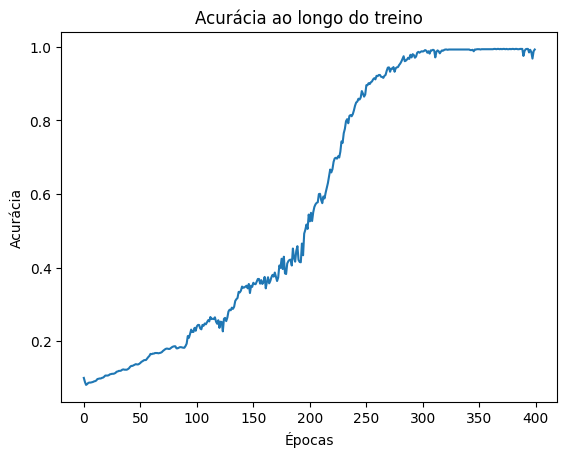

In [ ]:
plt.plot(range(EPOCHS), acc_list)
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.title("Acurácia ao longo do treino")
plt.show()

##Predição dos dados de teste

In [ ]:
local_acc = 0
pred = []
for row, target in zip(test.drop(columns=['target']).values, test['target'].values):
    input_row = np.array([row])

    hidden1Output = hiddenLayer1.evaluate(input_row)
    hidden2Output = hiddenLayer2.evaluate(hidden1Output)
    output = outputLayer.evaluate(hidden2Output)
    out_categorical = to_categorical(output)
    pred.append(out_categorical)

    local_acc += acc(out_categorical, target)
print('Acurácia em teste: ' + str((local_acc/test['target'].shape[0]) * 100) + '%')

Acurácia em teste: 96.29629629629629%


###Matriz de confusão em teste

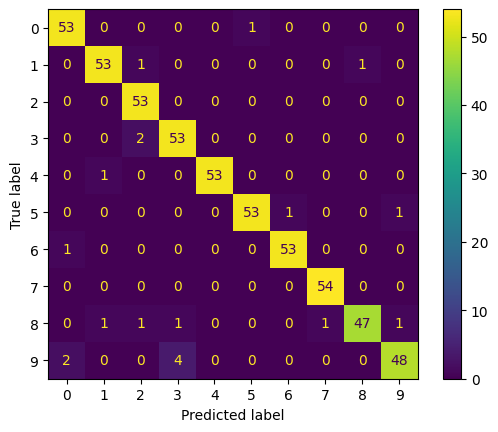

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(test['target'].values, pred)
cm_display = ConfusionMatrixDisplay(cm).plot()